# import requirements


In [132]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from numpy import cov
from numpy import std
from sklearn.feature_selection import  mutual_info_classif

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# preparing data


In [5]:
def loadData(trainingFile, testingFile):
    
    def convertDataframe(inputFile):
        data = pd.DataFrame(columns=range(100000))
        
        for i in range(len(inputFile)):
            record = np.fromstring(inputFile[i], dtype=int, sep=' ')
            record_bool = [0 for j in range(100000)]
            for col in record:
                record_bool[col-1] = 1
            
            data.loc[i] = record_bool
            
        return data
    
    with open(trainingFile, "r") as fr1:
        trainFile = fr1.readlines()
    
    #Split each line in the two files into label and data  
    train_data_list = []
    train_labels_list = []
    
    for inputData in trainFile:
        train_labels_list.append(inputData[0])
        
        #Remove the activity label (0/1) and new line character from each record
        inputData = inputData.replace("0\t", "")
        inputData = inputData.replace("1\t", "")
        inputData = inputData.replace("\n", "")
        train_data_list.append(inputData)
    
    train_labels = np.asarray(train_labels_list)
    train_data = convertDataframe(train_data_list)
        
    with open(testingFile, "r") as fr2:
        testFile = fr2.readlines()
    
    test_data = convertDataframe(testFile)
            
    return train_data, test_data, train_labels

# reading data

In [6]:
train_data, test_data, train_labels = loadData('/content/drive/My Drive/ISC/project/train.dat.txt', '/content/drive/My Drive/ISC/project/test.dat.txt')

In [7]:
test_labels = pd.read_csv('/content/drive/My Drive/ISC/project/test_labels.txt', header = None)

# SVM

In [8]:
def SVM(train_data,train_labels,test_data,test_labels):
  newsvm = SVC(kernel='linear', C=0.5)
  newsvm.fit(train_data, train_labels)
  y_predicted = newsvm.predict(test_data)
  y = np.zeros(test_labels.shape[0])
  for i in range (test_labels.shape[0]):
    y[i] = int(y_predicted[i])
  disp = ConfusionMatrixDisplay(confusion_matrix(test_labels,y, labels=[0,1], sample_weight=None, normalize=None),display_labels=[0,1])
  disp.plot()
  acc = np.count_nonzero((y==test_labels[0]).astype('uint8')) / test_labels.shape[0]
  print('acuuracy = ' ,acc)


# main data

acuuracy =  0.9314285714285714


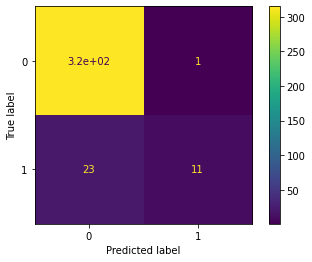

In [82]:
SVM(train_data,train_labels,test_data,test_labels)

# Filter $\rightarrow$ Basic Filter $\rightarrow$ Constant Features

first we calculate value of variance for each feature.

In [13]:
var = np.var(np.array(train_data),axis=0)

then we find features with 0  variance value.

In [123]:
delete_arg =[]
for i in range (var.shape[0]):
  if (var[i]== 0):
    delete_arg.append(i)

then we remove features with 0 variance value from train and test data.

In [124]:
train_con = train_data
test_con = test_data
train_con = train_con.drop(delete_arg,1)
test_con = test_con.drop(delete_arg,1)
print('features reduced to',train_con.shape[1] )

features reduced to 88119


at last,we predict test data labels by SVM function.

acuuracy =  0.9314285714285714


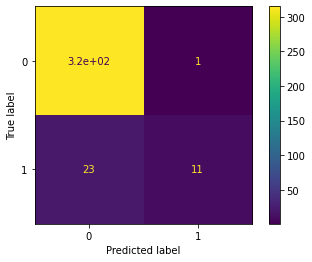

In [25]:
SVM(train_con,train_labels,test_con,test_labels)

# Filter $\rightarrow$ Correlation Filter $\rightarrow$ Pearson Correlation Coefficient


The Pearson correlation coefficient is probably the most widely used measure for linear relationships between two normal distributed variables and thus often just called "correlation coefficient". Usually, the Pearson coefficient is obtained via a Least-Squares fit and a value of 1 represents a perfect positive relation-ship, -1 a perfect negative relationship, and 0 indicates the absence of a relationship between variables.

$\rho = \frac{\text{cov}(X,Y)}{\sigma_x \sigma_y}$

In [105]:
def pearson(X,y):
  corr=[]
  for i in range(X.shape[1]):
    corr_each = np.cov(X[i].astype(float),y.astype(float))[0][1]/((np.std(X[i].astype(float))+0.00001)*(np.std(y.astype(float)+0.00001)))
    corr.append(corr_each)
  return corr 

In [94]:
y = np.zeros(800)
for i in range (800):
    y[i] = int(train_labels[i])

In [106]:
corr = pearson(train_data,y)

in this part,we choose a proper thershold for removing features that  are less correlated with labels.

In [129]:
thershold = 0.01
delete_arg =[]
for i in range (len(corr)):
  if (abs(corr[i]) <= thershold):
    delete_arg.append(i)

In [131]:
train_pear = train_data
test_pear = test_data
train_pear = train_pear.drop(delete_arg,1)
test_pear = test_pear.drop(delete_arg,1)
print('features reduced to',train_pear.shape[1] )

features reduced to 79282


acuuracy =  0.9314285714285714


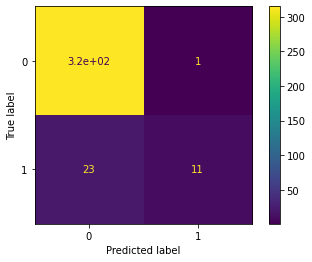

In [118]:
SVM(train_pear,train_labels,test_pear,test_labels)

# Filter $\rightarrow$ Statistical & Ranking Filter $\rightarrow$ Mutual Information

Mutual information is calculated between two variables and measures the reduction in uncertainty for one variable given a known value of the other variable.

A quantity called mutual information measures the amount of information one can obtain from one random variable given another.

The mutual information between two random variables X and Y can be stated formally as follows:

I(X ; Y) = H(X) – H(X | Y)
Where I(X ; Y) is the mutual information for X and Y, H(X) is the entropy for X and H(X | Y) is the conditional entropy for X given Y. The result has the units of bits.

Mutual information is a measure of dependence or “mutual dependence” between two random variables. As such, the measure is symmetrical, meaning that I(X ; Y) = I(Y ; X).

The MI between two descrete random variables $U=(u_{1},u_{2},...,u_{k})$ and $V=(v_{1},v_{2},...,v_{k})$ is defined as:

$I(U,V)=\sum_{u}\sum_{v}p(u,v)log\frac{p(u,v)}{p(u)p(v)}$

where $p(u,v)$ is a joint density funcyion and $p(u)$ and $p(v)$ are the marginal density functions.

In [133]:
mi = mutual_info_classif(train_data, y) 
len(mi)

100000

In [137]:
mi = pd.Series(mi)
mi.index = train_data.columns

sorting values in the descending order.

In [139]:
mi.sort_values(ascending=False, inplace = True)

we choose top 100 features.

In [155]:
drop_index = []
for i in range(100,100000):
  drop_index.append(mi.index[i])

In [156]:
train_MI = train_data
test_MI = test_data
train_MI = train_MI.drop(drop_index,1)
test_MI = test_MI.drop(drop_index,1)
print('features reduced to',train_MI.shape[1] )

features reduced to 100


acuuracy =  0.9371428571428572


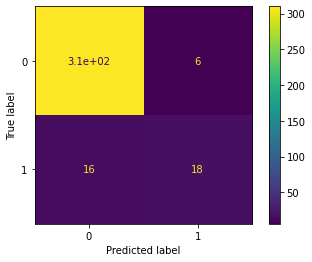

In [157]:
SVM(train_MI,train_labels,test_MI,test_labels)